In [1]:
start = "2024-01-01"
end = "2024-03-01"
interval = "1h"
tickers = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT", "ADAUSDT", "AVAXUSDT", "DOGEUSDT", "TRXUSDT",
           "DOTUSDT", "LINKUSDT", "SHIBUSDT", "LTCUSDT", "BCHUSDT", "UNIUSDT"]

In [2]:
from modules.data_services.data_pipeline import load_data

# 1. Load data
df = load_data(
    tickers=tickers,
    start=start,
    end=end,
    interval=interval,
)
print(df.head())

                      BTCUSDT  ETHUSDT  BNBUSDT  SOLUSDT  XRPUSDT  ADAUSDT  \
open_time                                                                    
2024-01-01 00:00:00  42475.23  2295.51    314.4   101.96   0.6162   0.5979   
2024-01-01 01:00:00  42613.56  2303.72    315.3   104.12   0.6185   0.6023   
2024-01-01 02:00:00  42581.10  2293.02    310.9   103.69   0.6154   0.5995   
2024-01-01 03:00:00  42330.49  2273.81    309.2   103.07   0.6130   0.5956   
2024-01-01 04:00:00  42399.99  2279.55    309.2   102.62   0.6116   0.5953   

                     AVAXUSDT  DOGEUSDT  TRXUSDT  DOTUSDT  LINKUSDT  SHIBUSDT  \
open_time                                                                       
2024-01-01 00:00:00     38.94   0.08983  0.10832    8.267    15.122   0.00001   
2024-01-01 01:00:00     39.39   0.09016  0.10820    8.294    15.167   0.00001   
2024-01-01 02:00:00     39.04   0.08980  0.10781    8.253    15.065   0.00001   
2024-01-01 03:00:00     38.51   0.08921  0.10711

In [3]:
# 1. Perform Engle-Granger cointegration test

import numpy as np
from modules.pair_selection.statistical_tests import pearson_correlation, engle_granger_cointegration

log_returns = np.log(df / df.shift(1)).dropna()
corr_log_returns_df = pearson_correlation(log_returns).reset_index(drop=True)
corr_log_returns_df = corr_log_returns_df.rename(columns={'corr': 'corr_log_returns'})

eg_df = engle_granger_cointegration(df, tickers).sort_values('eg_p_value', ascending=True).reset_index(drop=True)

from modules.data_services.data_pipeline import merge_by_pair

merged_df = merge_by_pair(
    dfs=[corr_log_returns_df, eg_df],
    keep_cols=[
        ['corr_log_returns'],
        ['eg_p_value']
    ]
).reset_index(drop=True)
merged_df['corr_log_returns * (1 - eg_p_value)'] = merged_df['corr_log_returns'] * (1 - merged_df['eg_p_value'])
merged_df.sort_values('corr_log_returns * (1 - eg_p_value)', ascending=False, inplace=True)
merged_df.reset_index(drop=True, inplace=True)
print(merged_df.head(5))

              pair  corr_log_returns  eg_p_value  \
0  BTCUSDT-SOLUSDT          0.674951    0.060690   
1  BTCUSDT-ADAUSDT          0.711226    0.109194   
2  BTCUSDT-BCHUSDT          0.633006    0.042415   
3  ETHUSDT-ADAUSDT          0.753668    0.198458   
4  DOTUSDT-BCHUSDT          0.597626    0.047072   

   corr_log_returns * (1 - eg_p_value)  
0                             0.633988  
1                             0.633565  
2                             0.606157  
3                             0.604097  
4                             0.569494  


                      BTCUSDT  BCHUSDT
open_time                             
2024-03-01 00:00:00  61501.11    304.2
2024-03-01 01:00:00  61214.35    306.1
2024-03-01 02:00:00  60980.00    313.5
2024-03-01 03:00:00  61105.91    317.5
2024-03-01 04:00:00  61524.09    315.1


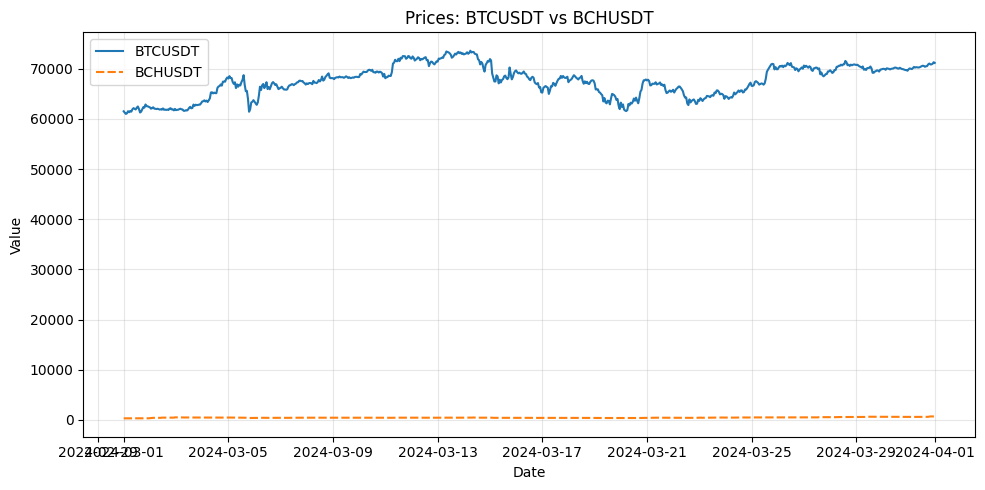

In [4]:
# 2. Load chosen pair data

from modules.data_services.data_pipeline import load_pair
from modules.visualization.plots import plot_prices

pair = merged_df['pair'][2].split('-')
x = pair[0]
y = pair[1]

start = "2024-03-01"
end = "2024-04-01"

pair = load_pair(
    x=x,
    y=y,
    start=start,
    end=end,
    interval=interval
)
print(pair.data.head())
plot_prices(pair)

C:\Users\Damia\PyCharmProjects\research-paper\modules\visualization\plots.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize="small")


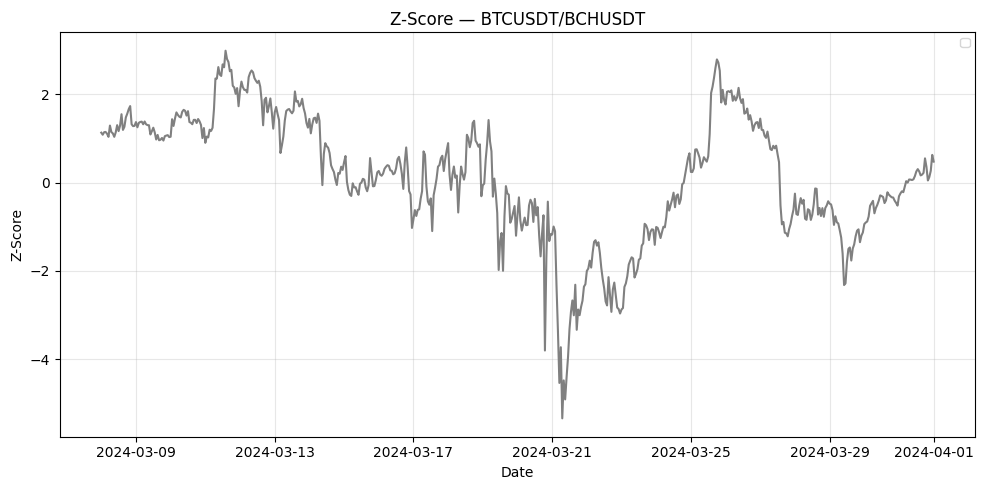

In [5]:
# 3. Calculate rolling z-score with rolling beta

from modules.data_services.data_pipeline import calculate_rolling_zscore_with_rolling_beta
from modules.visualization.plots import plot_zscore

calculate_rolling_zscore_with_rolling_beta(pair, 7*24)
plot_zscore(pair)

                      BTCUSDT  BCHUSDT  beta  spread  z_score  \
open_time                                                       
2024-03-01 00:00:00  61501.11    304.2   NaN     NaN      NaN   
2024-03-01 01:00:00  61214.35    306.1   NaN     NaN      NaN   
2024-03-01 02:00:00  60980.00    313.5   NaN     NaN      NaN   
2024-03-01 03:00:00  61105.91    317.5   NaN     NaN      NaN   
2024-03-01 04:00:00  61524.09    315.1   NaN     NaN      NaN   

                     entry_threshold  exit_threshold  position_size  action  
open_time                                                                    
2024-03-01 00:00:00                2               0              1       0  
2024-03-01 01:00:00                2               0              1       0  
2024-03-01 02:00:00                2               0              1       0  
2024-03-01 03:00:00                2               0              1       0  
2024-03-01 04:00:00                2               0              1       0 

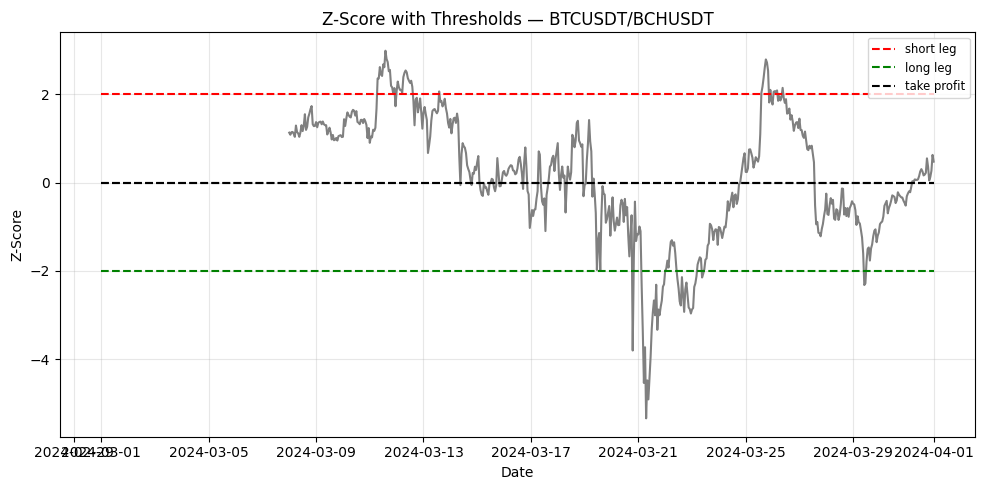

In [6]:
# 4. Generate action space

from modules.performance.strategy import generate_action_space
from modules.visualization.plots import plot_zscore_with_thresholds

entry_threshold = 2
exit_threshold = 0
position_size = 1

generate_action_space(
    pair_data=pair,
    entry_threshold=entry_threshold,
    exit_threshold=exit_threshold,
    position_size=position_size
)
print(pair.data.head())
plot_zscore_with_thresholds(pair)

In [7]:
# 5. Benchmark strategy

from modules.performance.strategy import benchmark_strategy

initial_cash = 100000
fee_rate = 0.0005

benchmark_strategy(
    pair_data=pair,
    initial_cash=initial_cash,
    fee_rate=fee_rate
)
print(pair.data)

                      BTCUSDT  BCHUSDT      beta        spread   z_score  \
open_time                                                                  
2024-03-01 00:00:00  61501.11    304.2       NaN           NaN       NaN   
2024-03-01 01:00:00  61214.35    306.1       NaN           NaN       NaN   
2024-03-01 02:00:00  60980.00    313.5       NaN           NaN       NaN   
2024-03-01 03:00:00  61105.91    317.5       NaN           NaN       NaN   
2024-03-01 04:00:00  61524.09    315.1       NaN           NaN       NaN   
...                       ...      ...       ...           ...       ...   
2024-03-31 20:00:00  70840.00    680.5  7.409058  65798.136203  0.049336   
2024-03-31 21:00:00  70856.00    678.8  6.890541  66178.701101  0.128036   
2024-03-31 22:00:00  70970.00    680.8  6.480255  66558.242287  0.269824   
2024-03-31 23:00:00  71280.01    678.7  6.200623  67071.647236  0.629225   
2024-04-01 00:00:00  71152.86    683.4  6.058996  67012.142130  0.476978   

           

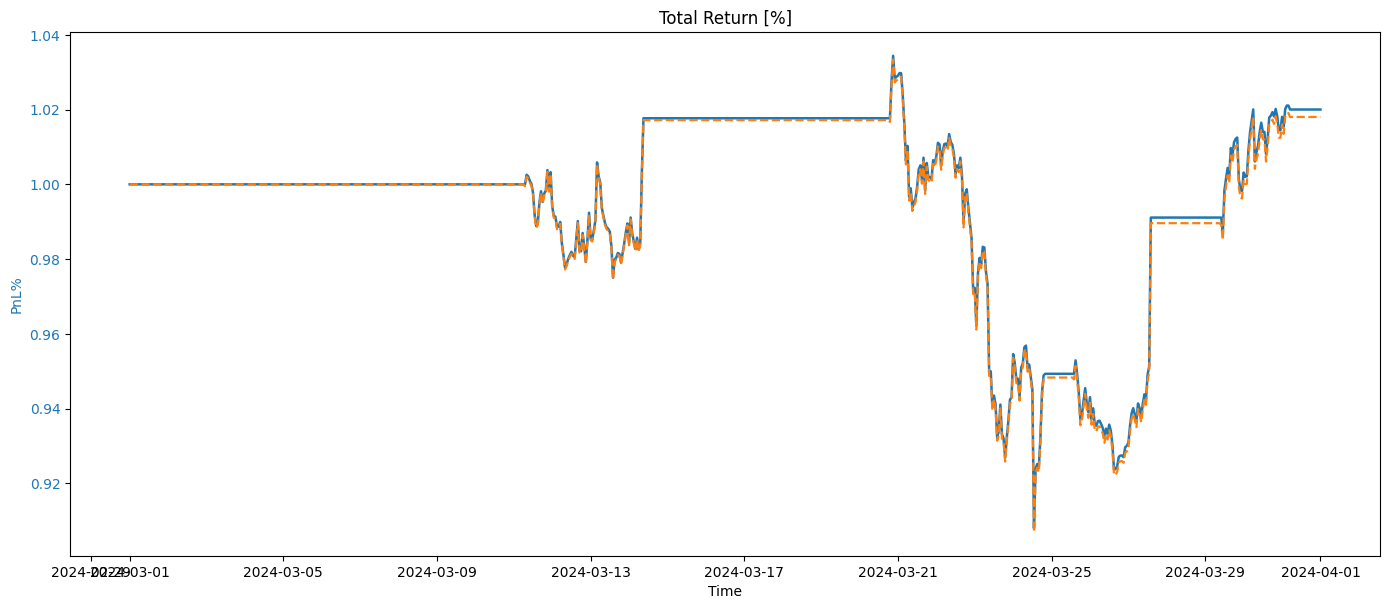

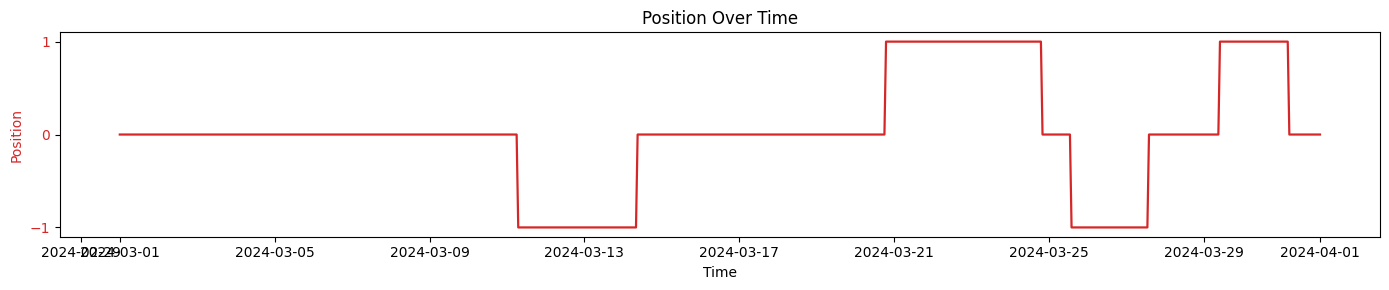

In [8]:
from modules.visualization.plots import plot_pnl, plot_positions

plot_pnl(pair)
plot_positions(pair)

In [9]:
from modules.performance.strategy import calculate_stats

stats = calculate_stats(pair)
print(stats)

{'total_return_brutto': 2.0019530765922777, 'sharpe_brutto': 0.8402984618823164, 'std_brutto': 0.0037420197261108816, 'max_drawdown_brutto': -12.220427248843983, 'total_return_netto': 1.8019530765922775, 'sharpe_netto': 0.7738949208022377, 'std_netto': 0.0037464998941858256, 'max_drawdown_netto': -12.232252705987303}
